# R processing and plotting of phylo analyses

# TO be combined into other R notebook????

In [8]:
# necessary for me on MedicineBow cluster
 .libPaths(c("/cluster/medbow/home/sharrin2/R/x86_64-pc-linux-gnu-library/4.4",
            "/apps/u/spack/gcc/14.2.0/r/4.4.0-w7xoohc/rlib/R/library"))


# load up some packages
library(ape)
library(phytools)


Loading required package: maps



In [11]:
# Load up the paths we need

iq_file <- "/project/inbreh/radseq_cloud/iqtree_out/ruber.treefile"


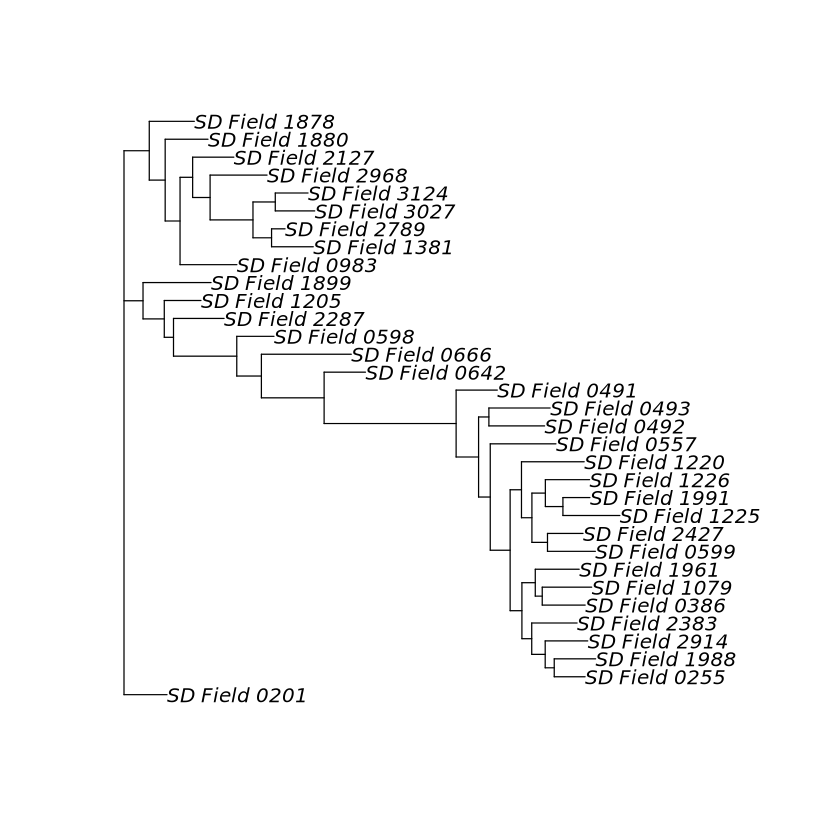

In [16]:
#plot IQTree

iq_tree <- read.tree(iq_file)

# Use functions from ape to plot the tree

plot.phylo(iq_tree) # plot the tree
